In [1]:
from ipynb.fs.full.utils import *
from PIL import ImageOps

In [2]:
def detect_faces_api(photo, bucket):
    client=boto3.client('rekognition')
    try:
        response = client.detect_faces(Image={'S3Object':{'Bucket':bucket,'Name':photo}},Attributes=['ALL'])
    except ClientError:
        print("Couldn't detect faces in %s.", photo)
        raise
    else:
        return {'face_details': response['FaceDetails'], 'face_count': len(response['FaceDetails'])}

In [3]:
def detect_celebrities_api(photo, bucket, local=False, grey=False):
    client = boto3.client('rekognition')
    
    try:
        if local:
            with open("../images/" + photo, 'rb') as img_file:
                img = Image.open(io.BytesIO(img_file.read()))
                w, h = img.size

                if w < 80 or h < 80:
                    raise Exception("Image {} too small: ({},{}).Each dimension should at least be 80 pixels".format(photo, w, h))

                if grey:
                    gray_image = ImageOps.grayscale(img)
                    gray_image.save(photo)
            
            with open("../images/" + photo, 'rb') as img_file:
                response = client.recognize_celebrities(Image={'Bytes': img_file.read()})
        else:
            response = client.recognize_celebrities(
                Image={
                'S3Object': {
                'Bucket': bucket,
                'Name': photo,
            }})
        celebrities = [
                        {celeb['Name']: (celeb['Face']['BoundingBox'], 
                        celeb['Face']['Confidence'])} for celeb in response['CelebrityFaces']
                      ]
        other_faces = [face for face in response['UnrecognizedFaces']]
    except Exception as e:
        print("Couldn't detect celebrities in %s.", photo)
        raise e
    else:
        return celebrities, other_faces

In [4]:
def detect_celebrities(photos, bucket, local, grey=False, bg_text=True):
    for photo in photos:      
        try:
            # download and save the image from the bucket so we can display it
            obj = get_object(bucket, photo, "../images/" + photo)
            with open("../images/" + photo, 'rb') as img_file:
                photo_bytes = img_file.read()

            celebs = detect_celebrities_api(photo, bucket, local=local, grey=grey)

            bounding_boxes = []
            labels = []

            # iterate through celebs
            for celeb in celebs[0]:
                name = list(celeb.keys())[0]
                labels.append(["{} {}".format(name, '%.3f' % celeb[name][1]), "Top", "Left"])
                bounding_boxes.append(celeb[name][0])
            print(labels)

            colors=['blue'] * len(labels)
            show_bounding_boxes(photo_bytes, bounding_boxes, colors, labels=labels, bg_text=bg_text)
        except Exception as e:
            print(repr(e))

In [5]:
def detect_celebrities_cropped(photos, bucket, grey=False):
    for photo in photos:
        try:
            # download and save the image from the bucket so we can display it
            obj = get_object(bucket, photo, "../images/" + photo)
            with open("../images/" + photo, 'rb') as img_file:
                photo_bytes = img_file.read()

            faces = detect_faces_api(photo, bucket)

            bounding_boxes = []
            for face in faces['face_details']:
                bounding_boxes.append(face['BoundingBox'])

            cropped_photos = crop_bounding_boxes(photo, photo_bytes, bounding_boxes)

            labels = []
            for cropped_photo in cropped_photos:
                cropped_bbs = []
                celebs = detect_celebrities_api(cropped_photo, bucket, local=True, grey=grey)
                print(celebs)
                for celeb in celebs[0]:
                    name = list(celeb.keys())[0]
                    labels.append(["{}, {}".format(name, celeb[name][1]), "Top", "Left"])
                    cropped_bbs.append(celeb[name][0])

            colors=['blue'] * len(labels)
            show_bounding_boxes(photo_bytes, bounding_boxes, colors, labels=labels)
        except Exception as e:
            print(repr(e))

In [6]:
def test():
    photos=['hackerman.png', 'avengers_cast.jpg', 'avengers_cast_2.jpg']
    bucket='labs-rekognition-demo-bucket'

    detect_celebrities(photos, bucket, False, grey=False)

In [7]:
def test_cropped():
    photos=['avengers_cast.jpg']
    bucket='labs-rekognition-demo-bucket'

    detect_celebrities_cropped(photos, bucket, grey=False)

[['Rami Malek 99.999', 'Top', 'Left']]


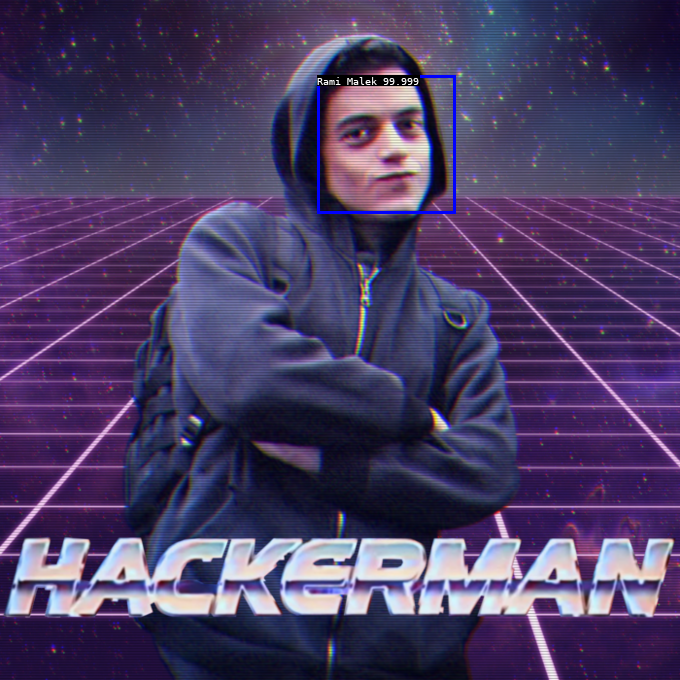

[['Benedict Cumberbatch 99.999', 'Top', 'Left'], ['Paul Rudd 99.992', 'Top', 'Left'], ['Jeremy Renner 100.000', 'Top', 'Left'], ['Chris Pratt 100.000', 'Top', 'Left'], ['Don Cheadle 99.994', 'Top', 'Left'], ['Anthony Mackie 99.997', 'Top', 'Left'], ['Robert Downey Jr. 100.000', 'Top', 'Left'], ['Elizabeth Olsen 99.295', 'Top', 'Left'], ['Chris Hemsworth 100.000', 'Top', 'Left'], ['Mack Robinson 99.876', 'Top', 'Left'], ['Evangeline Lilly 100.000', 'Top', 'Left']]


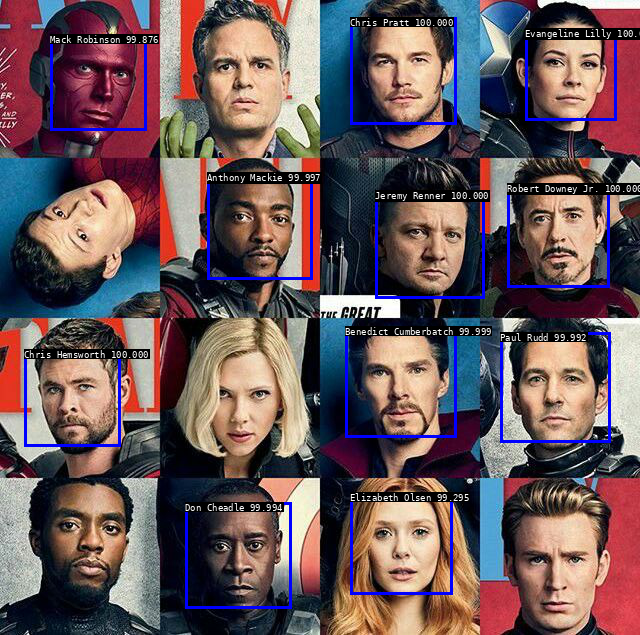

[['Paul Bettany 99.986', 'Top', 'Left'], ['Mark Ruffalo 99.979', 'Top', 'Left'], ['Robert Downey Jr. 99.999', 'Top', 'Left'], ['Jeremy Renner 100.000', 'Top', 'Left'], ['Aaron Taylor-Johnson 100.000', 'Top', 'Left'], ['Chris Evans 99.977', 'Top', 'Left'], ['Chris Hemsworth 99.998', 'Top', 'Left'], ['Elizabeth Olsen 99.931', 'Top', 'Left'], ['Scarlett Johansson 99.989', 'Top', 'Left'], ['Andy Serkis 99.994', 'Top', 'Left']]


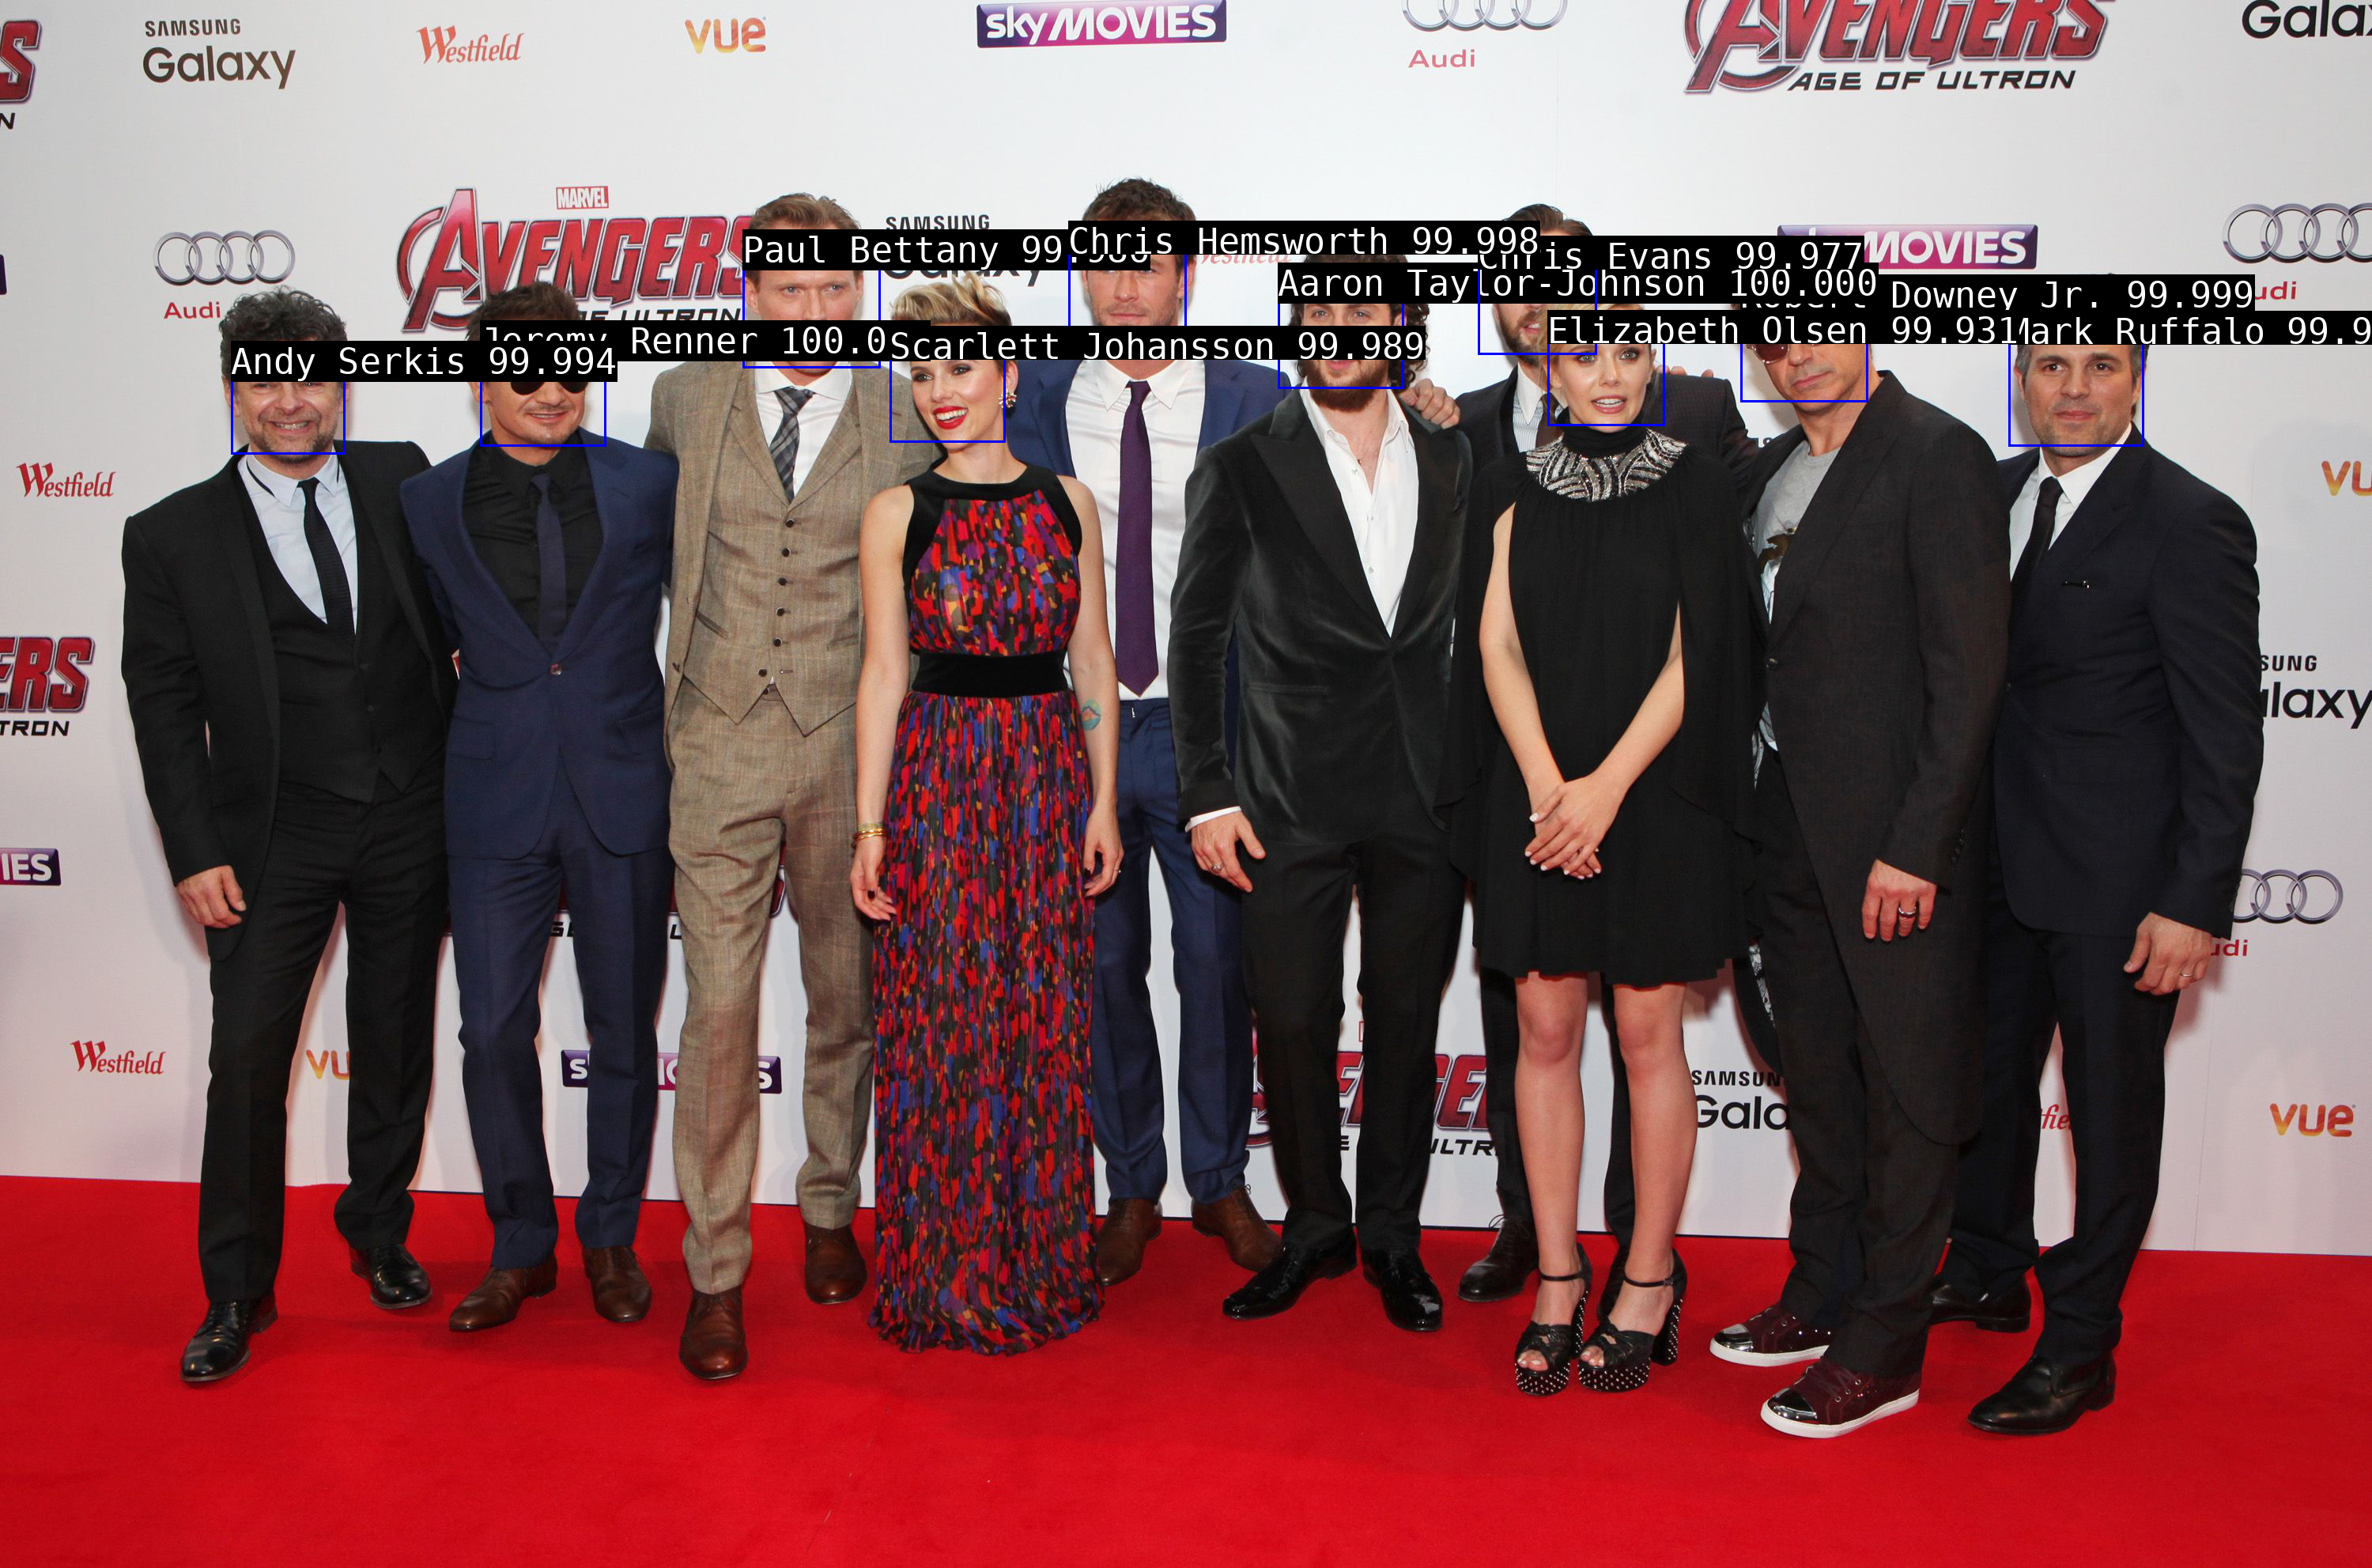

In [8]:
test()